# Imports & Configuration

## Installations

In [0]:
%pip install geopandas

  Obtaining dependency information for geopandas from https://files.pythonhosted.org/packages/54/e4/fac19dc34cb686c96011388b813ff7b858a70681e5ce6ce7698e5021b0f4/geopandas-1.1.2-py3-none-any.whl.metadata
  Using cached geopandas-1.1.2-py3-none-any.whl.metadata (2.3 kB)
  Obtaining dependency information for numpy>=1.24 from https://files.pythonhosted.org/packages/5d/9d/7862db06743f489e6a502a3b93136d73aea27d97b2cf91504f70a27501d6/numpy-2.4.1-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata
  Using cached numpy-2.4.1-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (6.6 kB)
  Obtaining dependency information for pyogrio>=0.7.2 from https://files.pythonhosted.org/packages/89/a4/0aef5837b4e11840f501e48e01c31242838476c4f4aff9c05e228a083982/pyogrio-0.12.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata
  Using cached pyogrio-0.12.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (5.9 kB)
  Obtaining dependency information for pandas>=2.0.0 from https://fi

## Settings

In [0]:
# Imports
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, lit, broadcast, rand, count, when
from delta.tables import DeltaTable

# Parameters
OVERTURE_PATH = "wasbs://release@overturemapswestus2.blob.core.windows.net/2025-12-17.0/theme=places/type=place"
OUTPUT_TABLE = "Itav_World_POIs"
CATEGORIES_CONFIG = {
    "nightlife": ['nightclub', 'bar', 'pub', 'casino', 'comedy_club', 'jazz_club', 'biergarten', 'karaoke_box', 'lounge'],
    "nature": ['national_park', 'nature_reserve', 'wildlife_refuge', 'waterfall', 'hot_spring', 'glacier', 'volcano', 'forest', 'mountain_peak', 'wetland'],
    "tourist": ['museum', 'aquarium', 'zoo', 'theme_park', 'water_park', 'castle', 'palace', 'archaeological_site', 'ruins', 'pagoda', 'planetarium', 'observatory'],
    "shopping": ['shopping_mall', 'outlet_store', 'marketplace', 'department_store', 'flea_market', 'shopping_centre'],
    "relaxation": ['spa', 'sauna', 'thermal_bath', 'public_bath', 'resort', 'massage', 'beauty_salon', 'beach_resort']
}
CONFIDENCE_THRESHOLD = 0.80

print(f"Configuration loaded.")
print(f"Reading from: {OVERTURE_PATH}")
print(f"Categories configured: {list(CATEGORIES_CONFIG.keys())}")


Configuration loaded.
Reading from: wasbs://release@overturemapswestus2.blob.core.windows.net/2025-12-17.0/theme=places/type=place
Categories configured: ['nightlife', 'nature', 'tourist', 'shopping', 'relaxation']


## Configuration Inference

In [0]:
# Infere all tags
ALL_TAGS = [tag for tags in CATEGORIES_CONFIG.values() for tag in tags]

# Create mapping data frame
mapping_data = []
for category, tags in CATEGORIES_CONFIG.items():
    for tag in tags:
        mapping_data.append((tag, category))
mapping_schema = ["tag", "category"]
mapping_df = spark.createDataFrame(mapping_data, schema=mapping_schema)
display(mapping_df)

tag,category
nightclub,nightlife
bar,nightlife
pub,nightlife
casino,nightlife
comedy_club,nightlife
jazz_club,nightlife
biergarten,nightlife
karaoke_box,nightlife
lounge,nightlife
national_park,nature


# Data Ingestion

In [0]:
# Load Data
print("Acquiring data from Overture Maps...")
overture_df = spark.read.format("parquet").load(OVERTURE_PATH)
print("Data acquired from Overture Maps successfully.")

Acquiring data from Overture Maps...
Data acquired from Overture Maps successfully.


# Data Processing

## Initial Select

In [0]:
# Select relevant columns
core_df = overture_df.select("id", "names", "categories", "confidence", "bbox", "addresses", "sources")

## Filter

### Coordinates

In [0]:
# Filter out data with invalid coordinates
valid_coords_df = core_df.filter(
    col("bbox.ymin").isNotNull() & 
    col("bbox.xmin").isNotNull()
)

total_records = valid_coords_df.count()
print(f"Total valid coordinate records: {total_records}")

Total valid coordinate records: 72417241


Geospatial indexing relies entirely on valid latitude and longitude coordinates.<br>
Records missing this structural data cannot be mapped or recommended, making their removal a mandatory technical prerequisite before any further processing.

### Confidence

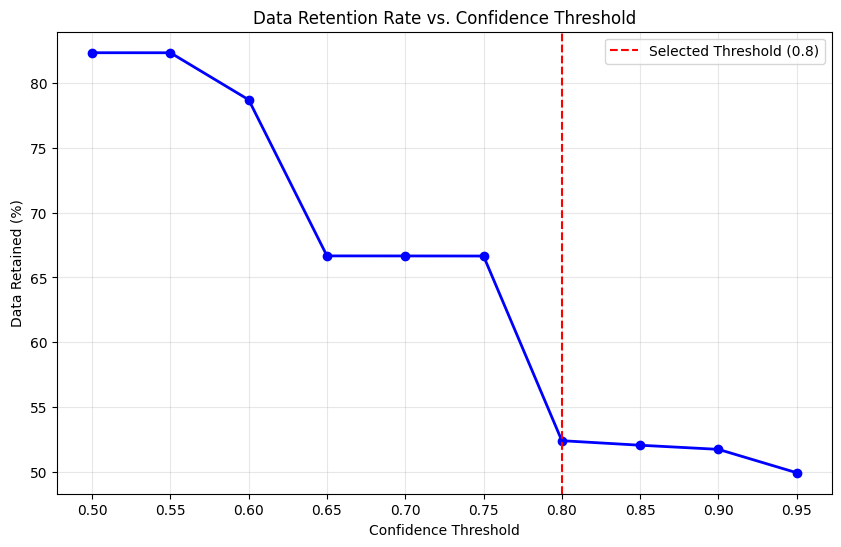

In [0]:
thresholds = np.arange(0.5, 1.0, 0.05)
counts = [{'Threshold': t, 'Retention Percentage': (valid_coords_df.filter(col("confidence") > t).count() / total_records) * 100} for t in thresholds]
pdf_curve = pd.DataFrame(counts)

plt.figure(figsize=(10, 6))
plt.plot(pdf_curve['Threshold'], pdf_curve['Retention Percentage'], marker='o', linestyle='-', color='b', linewidth=2)
plt.axvline(x=CONFIDENCE_THRESHOLD, color='r', linestyle='--', label=f'Selected Threshold ({CONFIDENCE_THRESHOLD})')
plt.title('Data Retention Rate vs. Confidence Threshold')
plt.xlabel('Confidence Threshold')
plt.ylabel('Data Retained (%)')
min_diff = min([j - i for i, j in zip(thresholds[:-1], thresholds[1:])])
xticks = [round(thresholds[0] + i * min_diff, 2) for i in range(int((thresholds[-1] - thresholds[0]) / min_diff) + 1)]
plt.xticks(xticks)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

The curve illustrates the percentage of data retained at various confidence thresholds.<br>
The 'elbow' at 0.80 indicates the point of diminishing returns, where raising the threshold further causes significant data loss without proportionally gaining quality.

---

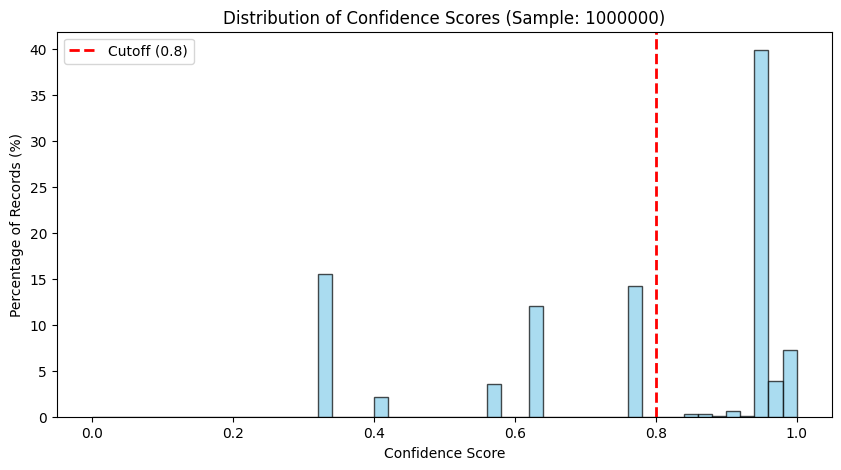

In [0]:
limit_size = 1000000
sample_conf = valid_coords_df.select("confidence").orderBy(rand()).limit(limit_size).toPandas()

plt.figure(figsize=(10, 5))
weights = np.ones(len(sample_conf)) / len(sample_conf) * 100
plt.hist(sample_conf['confidence'], bins=50, weights=weights, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=CONFIDENCE_THRESHOLD, color='red', linestyle='dashed', linewidth=2, label=f'Cutoff ({CONFIDENCE_THRESHOLD})')
plt.title(f'Distribution of Confidence Scores (Sample: {limit_size})')
plt.xlabel('Confidence Score')
plt.ylabel('Percentage of Records (%)')
plt.legend()
plt.show()

This distribution shows the frequency of confidence scores across the dataset.<br>
The clear separation allows us to safely filter out the lower-end values (left of the red line) while preserving the high-density cluster of verified locations.

---

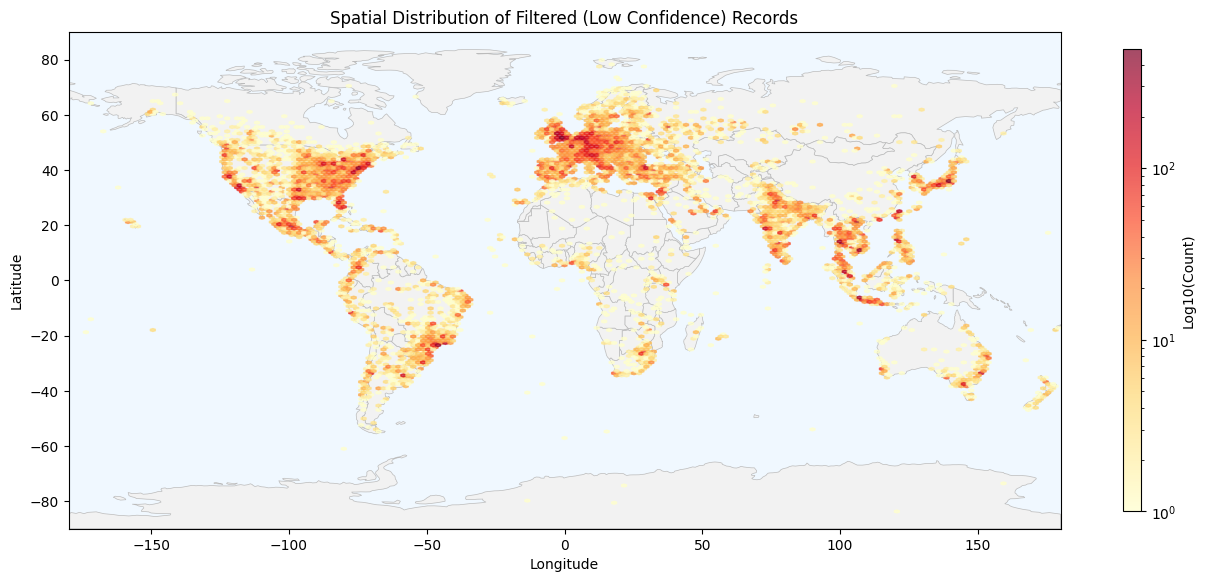

In [0]:
limit_size = 50000
grid_size_val = 200

rejected_sample = valid_coords_df.filter(col("confidence") < CONFIDENCE_THRESHOLD) \
    .select("bbox.xmin", "bbox.ymin") \
    .orderBy(rand()) \
    .limit(limit_size) \
    .toPandas()

fig, ax = plt.subplots(figsize=(16, 10))
try:
    import geopandas as gpd
    world_data_url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
    world = gpd.read_file(world_data_url)
    world.plot(ax=ax, color='#f2f2f2', edgecolor='#bbbbbb', linewidth=0.5)
except Exception as e:
    print(f"Note: World map background could not be loaded ({e}). Plotting data only.")
hb = ax.hexbin(
    rejected_sample['xmin'], 
    rejected_sample['ymin'], 
    gridsize=grid_size_val, 
    cmap='YlOrRd', 
    bins='log',
    mincnt=1,
    alpha=0.7,
    extent=[-180, 180, -90, 90]
)
cb = fig.colorbar(hb, ax=ax, label='Log10(Count)', shrink=0.6, aspect=25)
ax.set_facecolor('#f0f8ff')
ax.set_title('Spatial Distribution of Filtered (Low Confidence) Records')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim([-180, 180])
ax.set_ylim([-90, 90])
plt.show()

We analyze confidence scores to determine the optimal threshold that balances data quantity with quality.<br>
By visualizing the distribution and retention rates, we can empirically justify excluding low-confidence records that likely represent data noise or non-existent locations.

---

In [0]:
# Filter out invalid records
high_confidence_df = valid_coords_df.filter(col("confidence") > CONFIDENCE_THRESHOLD)
total_records = high_confidence_df.count()
print(f"Total valid records: {total_records}")

Total valid records: 37944847


## Missing Values

In [0]:
# Count Nulls per column
null_counts_row = high_confidence_df.select([
    count(when(col(c).isNull(), c)).alias(c)
    for c in high_confidence_df.columns
]).first()

null_counts_dict = null_counts_row.asDict()

for col_name, missing_count in null_counts_dict.items():
    if missing_count > 0:
        print(f"Column '{col_name}': {missing_count} nulls")
    else:
        print(f"Column '{col_name}': OK (0 nulls)")

Column 'id': OK (0 nulls)
Column 'names': OK (0 nulls)
Column 'categories': OK (0 nulls)
Column 'confidence': OK (0 nulls)
Column 'bbox': OK (0 nulls)
Column 'addresses': OK (0 nulls)
Column 'sources': OK (0 nulls)


## Category Identifier

In [0]:
# Create a category identifier column
df_with_category = high_confidence_df.join(
    broadcast(mapping_df),
    high_confidence_df["categories.primary"] == mapping_df["tag"],
    "inner"
)

## Final Select

In [0]:
# Select columns
final_df = df_with_category.select(
    col("id").alias("place_id"),
    col("names.primary").alias("name"),
    col("categories.primary").alias("subcategory"),
    col("category"),
    col("bbox.ymin").alias("latitude"),
    col("bbox.xmin").alias("longitude"),
    col("addresses")[0].getItem("locality").alias("city"),
    col("addresses")[0].getItem("country").alias("country_code"), 
    col("sources")[0].getItem("dataset").alias("data_source")
).dropDuplicates(["place_id", "category"])

# Save Data

In [0]:
print(f"Saving to unified Delta table: {OUTPUT_TABLE}...")
# Save Data
final_df.write.format("delta") \
    .mode("overwrite") \
    .partitionBy("category") \
    .option("overwriteSchema", "true") \
    .saveAsTable(OUTPUT_TABLE)

# Z-order over coordinates
delta_table = DeltaTable.forName(spark, OUTPUT_TABLE)
delta_table.optimize().executeZOrderBy(["latitude", "longitude"])

count = spark.table(OUTPUT_TABLE).count()
print(f"Saved {count} records to {OUTPUT_TABLE} partitioned by category.")

Saving to unified Delta table: Itav_World_POIs...
Saved 1502390 records to Itav_World_POIs partitioned by category.


# Validation

In [0]:
# Verify results
print("Verifying Output Tables:")

# Load table
loaded_df = spark.table(OUTPUT_TABLE)

for category in CATEGORIES_CONFIG.keys():
    print(f"\nSample data from: {OUTPUT_TABLE} (Category: {category})")
    
    # Filter and display
    display(
        loaded_df
        .filter(col("category") == category)
        .limit(5)
    )

Verifying Output Tables:

Sample data from: Itav_World_POIs (Category: nightlife)


place_id,name,subcategory,category,latitude,longitude,city,country_code,data_source
0002d50a-889d-4e96-8ada-214bb4b5d53f,Bar le villette,bar,nightlife,38.083557,13.359756,Palermo,IT,meta
00031822-acc1-4d49-94fc-fa3c55bb2c85,Alba torv,bar,nightlife,44.696835,8.034131,Alba,IT,meta
0003e4ba-a6cf-477a-b0f9-2bc844120ba7,Gin Jar Ale,bar,nightlife,53.750084,-2.7291293,Preston,GB,meta
00052331-3de3-49a4-924f-961658e91b06,Tavola Calda Bar,bar,nightlife,41.995064,12.48114,Roma,IT,meta
00066e3b-c804-49ef-8c6f-a27e56805982,Stará hospoda,pub,nightlife,50.136066,12.584644,Šabina,CZ,meta



Sample data from: Itav_World_POIs (Category: nature)


place_id,name,subcategory,category,latitude,longitude,city,country_code,data_source
003e93d8-822f-4d8b-91ba-6408053a7e63,Parque Nacional Campos del Tuyu,national_park,nature,-36.421936,-56.924496,General Lavalle,AR,meta
0078cbc5-8d30-4de0-ba9c-e0d09ef2e42f,Byklevsfallet,waterfall,nature,58.346226,12.414517,Vargön,SE,meta
00b4d723-dd03-4ec0-9ff5-cc8cd55dc6e4,Hörmann-forrás,nature_reserve,nature,47.358685,16.45988,Kőszeg,HU,meta
00bd3321-9584-409f-aac1-7b834b6968c8,Skógafoss,waterfall,nature,63.53205,-19.511381,Sveitarfélagið Árborg,IS,meta
0130abb9-14dc-4fec-8b80-f9c94df1e832,Karumsalvar,nature_reserve,nature,56.77443,16.625172,Kalmar län,SE,meta



Sample data from: Itav_World_POIs (Category: tourist)


place_id,name,subcategory,category,latitude,longitude,city,country_code,data_source
000e9038-a49a-4e4c-af13-3109e587f01c,Palazzo Forcella De Seta,palace,tourist,38.115986,13.374176,Palermo,IT,meta
000fc2bd-9578-4882-aab3-4d61f5db2c8d,ふるさと銀河線りくべつ鉄道,museum,tourist,43.467667,143.74278,足寄郡陸別町,JP,meta
0033b7e0-3650-42eb-91d1-4ad66445e1f1,Museo Terre di Confine,museum,tourist,41.41428,13.23961,Sonnino,IT,meta
0037f0f7-a6e3-488f-8095-26d32904e5c4,Wyatt House Museum,museum,tourist,46.394386,-63.78905,Summerside,CA,meta
00576d41-b45e-44eb-a196-750553ce665b,Regionalne Centrum Promocji Obszaru Natura 2000 Tarnobrzeska Dolina Wisły,museum,tourist,50.578583,21.675169,Tarnobrzeg,PL,meta



Sample data from: Itav_World_POIs (Category: shopping)


place_id,name,subcategory,category,latitude,longitude,city,country_code,data_source
001bf055-2131-4aa4-877f-4a74b3c9aa61,Argos Turo Sainsbury's Collection Point,department_store,shopping,50.26173,-5.068391,Truro,GB,meta
0029f5c3-fe90-4795-ad8e-6bd21e9dd996,Marshalls,department_store,shopping,46.05429,-118.36892,Walla Walla,US,meta
00416101-e83f-42a1-b166-cc00d00d85a9,Suburbia,department_store,shopping,19.426756,-98.91185,Texcoco,MX,meta
00452ac6-d392-4834-840a-a59865c85bd2,寶雅生活館,department_store,shopping,24.99985,121.51742,新北市,TW,meta
004eda96-9d17-4caa-bbde-2205d6b17943,Mercado de Arcelia,flea_market,shopping,18.323414,-100.28328,Arcelia,MX,meta



Sample data from: Itav_World_POIs (Category: relaxation)


place_id,name,subcategory,category,latitude,longitude,city,country_code,data_source
0000914d-0bf9-4416-8573-441b55d72db0,Catherine Azzaoui Art Cellulaire,beauty_salon,relaxation,49.183746,6.894058,Forbach,FR,meta
0000a3d9-9e39-4384-a725-466be28502cd,Salão Afrogil,beauty_salon,relaxation,-15.795149,-47.885044,Brasília,BR,meta
00024b03-89a9-44a0-aa8d-ee06563aaf0d,Black & White Studio,beauty_salon,relaxation,9.921766,-84.084625,San José,CR,meta
000682dd-1e2f-42ee-8cab-18bc0fb51780,Marie Jolie,beauty_salon,relaxation,-5.8544693,-35.23983,Natal,BR,meta
00073503-3d85-415a-bee2-7ad94ac178c4,Permanent Cosmetics of Ga,beauty_salon,relaxation,32.875355,-83.762375,Macon,US,meta
